In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
# Load the dataset
data = pd.read_csv('./data/Training.csv')
print(data.head())

# Convert symptoms to text
symptom_columns = data.columns[:-1]  # All columns except 'prognosis'
data['symptom_text'] = data[symptom_columns].apply(
    lambda row: ' '.join(col for col, val in row.items() if val == 1), axis=1
)

# Separate features and labels
X = data['symptom_text']
y = data['prognosis']

X.head()

   itching  skin_rash  nodal_skin_eruptions  continuous_sneezing  shivering  \
0        1          1                     1                    0          0   
1        0          1                     1                    0          0   
2        1          0                     1                    0          0   
3        1          1                     0                    0          0   
4        1          1                     1                    0          0   

   chills  joint_pain  stomach_pain  acidity  ulcers_on_tongue  ...  \
0       0           0             0        0                 0  ...   
1       0           0             0        0                 0  ...   
2       0           0             0        0                 0  ...   
3       0           0             0        0                 0  ...   
4       0           0             0        0                 0  ...   

   blackheads  scurring  skin_peeling  silver_like_dusting  \
0           0         0             

0    itching skin_rash nodal_skin_eruptions dischro...
1    skin_rash nodal_skin_eruptions dischromic_patches
2      itching nodal_skin_eruptions dischromic_patches
3                 itching skin_rash dischromic_patches
4               itching skin_rash nodal_skin_eruptions
Name: symptom_text, dtype: object

In [3]:
from sklearn.preprocessing import LabelEncoder

# Encode target labels into integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Save mapping for label decoding later
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

# Check class distribution
print(data['prognosis'].value_counts())

{'(vertigo) Paroymsal  Positional Vertigo': 0, 'AIDS': 1, 'Acne': 2, 'Alcoholic hepatitis': 3, 'Allergy': 4, 'Arthritis': 5, 'Bronchial Asthma': 6, 'Cervical spondylosis': 7, 'Chicken pox': 8, 'Chronic cholestasis': 9, 'Common Cold': 10, 'Dengue': 11, 'Diabetes ': 12, 'Dimorphic hemmorhoids(piles)': 13, 'Drug Reaction': 14, 'Fungal infection': 15, 'GERD': 16, 'Gastroenteritis': 17, 'Heart attack': 18, 'Hepatitis B': 19, 'Hepatitis C': 20, 'Hepatitis D': 21, 'Hepatitis E': 22, 'Hypertension ': 23, 'Hyperthyroidism': 24, 'Hypoglycemia': 25, 'Hypothyroidism': 26, 'Impetigo': 27, 'Jaundice': 28, 'Malaria': 29, 'Migraine': 30, 'Osteoarthristis': 31, 'Paralysis (brain hemorrhage)': 32, 'Peptic ulcer diseae': 33, 'Pneumonia': 34, 'Psoriasis': 35, 'Tuberculosis': 36, 'Typhoid': 37, 'Urinary tract infection': 38, 'Varicose veins': 39, 'hepatitis A': 40}
prognosis
Fungal infection                           120
Hepatitis C                                120
Hepatitis E                            

In [4]:
# Split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Tokenize and pad text
tokenizer = Tokenizer(num_words=1000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

max_length = 100  # Maximum sequence length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

In [5]:
# Define the model
model = Sequential([
    Embedding(input_dim=10000, output_dim=128, input_length=max_length),  # Embedding layer
    LSTM(64, return_sequences=True),  # LSTM layer
    GlobalAveragePooling1D(),  # Pooling layer
    Dropout(0.5),  # Dropout layer for regularization
    Dense(64, activation='relu'),  # Fully connected layer
    Dense(len(label_mapping), activation='softmax')  # Output layer (number of unique diseases)
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

c:\Users\Luthfi Hanif\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [6]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train_padded, y_train,
    validation_data=(X_test_padded, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

Epoch 1/100
123/123 - 4s - 32ms/step - accuracy: 0.0356 - loss: 3.6568 - val_accuracy: 0.0437 - val_loss: 3.2867
Epoch 2/100
123/123 - 2s - 18ms/step - accuracy: 0.0864 - loss: 2.9626 - val_accuracy: 0.1717 - val_loss: 2.4761
Epoch 3/100
123/123 - 2s - 18ms/step - accuracy: 0.1618 - loss: 2.4831 - val_accuracy: 0.3252 - val_loss: 2.1515
Epoch 4/100
123/123 - 2s - 18ms/step - accuracy: 0.2797 - loss: 1.9794 - val_accuracy: 0.3618 - val_loss: 1.7537
Epoch 5/100
123/123 - 2s - 18ms/step - accuracy: 0.3618 - loss: 1.6997 - val_accuracy: 0.4807 - val_loss: 1.4080
Epoch 6/100
123/123 - 2s - 18ms/step - accuracy: 0.4492 - loss: 1.4067 - val_accuracy: 0.5793 - val_loss: 1.1226
Epoch 7/100
123/123 - 2s - 20ms/step - accuracy: 0.5297 - loss: 1.2186 - val_accuracy: 0.6321 - val_loss: 0.9186
Epoch 8/100
123/123 - 3s - 21ms/step - accuracy: 0.5742 - loss: 1.0605 - val_accuracy: 0.6341 - val_loss: 0.7938
Epoch 9/100
123/123 - 3s - 21ms/step - accuracy: 0.6865 - loss: 0.8217 - val_accuracy: 0.8140 - 

In [7]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test_padded, y_test, verbose=2)
print(f"Test Accuracy: {accuracy:.2f}")

31/31 - 0s - 6ms/step - accuracy: 1.0000 - loss: 4.6124e-04
Test Accuracy: 1.00


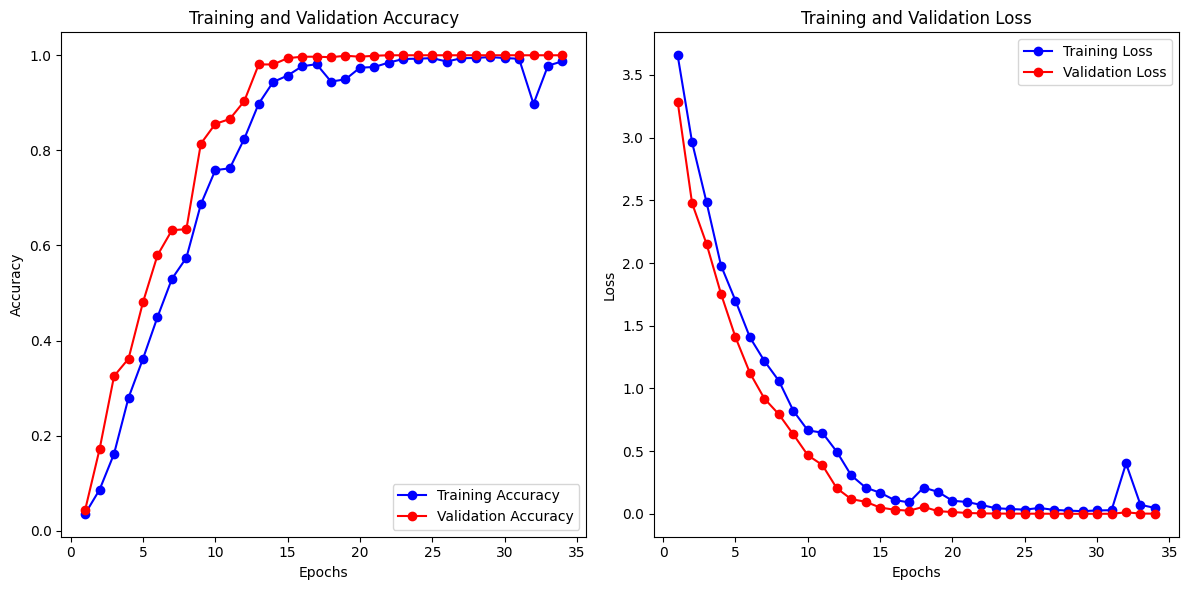

In [8]:
import matplotlib.pyplot as plt

# Extract metrics from the history object
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs = range(1, len(accuracy) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'ro-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()

In [9]:
# Predict disease for new symptoms
new_symptoms = "joint_pain neck_pain knee_pain hip_joint_pain"
new_symptoms_seq = tokenizer.texts_to_sequences([new_symptoms])
new_symptoms_padded = pad_sequences(new_symptoms_seq, maxlen=max_length, padding='post', truncating='post')

# Predict
prediction = model.predict(new_symptoms_padded)
predicted_class = np.argmax(prediction)
predicted_disease = label_encoder.inverse_transform([predicted_class])[0]

print(f"Predicted Disease: {predicted_disease}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
Predicted Disease: Osteoarthristis
